# 545 M2 Project: Digital Humanities Text Analysis

- Alishan Bhayani
- Tochukwu "Sylvester" Nwizu
- Giuseppe Schintu


`In this project, we aim to provide text Analysis in three different areas:`
- Character Description Analysis
- Character Occurrence Frequency Analysis
- Sentiment Analysis

## Run global libraries and functions

In [1]:
import requests, re, nltk
from bs4 import BeautifulSoup
from nltk import clean_html, download
from nltk.corpus import words, names
from collections import Counter
import operator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from re import split, sub
from requests import get

from bs4 import BeautifulSoup
from matplotlib.pyplot import clf, plot, show, text, title, xlabel, ylabel
from nltk import download
from nltk.corpus import stopwords
from pandas import DataFrame, Series
from seaborn import heatmap

nltk.download('stopwords', 'words', 'names', 'averaged_perceptron_tagger', 'punkt') #uncomment if not yet downloaded
english_words = set(words.words())
english_names = set(names.words())

# we may not care about the usage of stop words
stop_words = nltk.corpus.stopwords.words('english') + [
 'ut', '\'re','.', ',', '--', '\'s', '?', ')', '(', ':', '\'',
 '\"', '-', '}', '{', '&', '|', u'\u2014' ]

# We most likely would like to remove html markup
def cleanHtml (html):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    return soup .get_text()

# We also want to remove special characters, quotes, etc. from each word
def cleanWord (w):
    # r in r'[.,"\']' tells to treat \ as a regular character 
    # but we need to escape ' with \'
    # any character between the brackets [] is to be removed 
    wn = re.sub('[,"\.\'&\|:@>*;/=]', "", w)
    # get rid of numbers
    return re.sub('^[0-9\.]*$', "", wn)
       
# define a function to get text/clean/calculate frequency
def get_wf (URL, w_ml):
    # first get the web page
    r = requests .get(URL)
    
    # Now clean
    # remove html markup
    t = cleanHtml (r .text) .lower()
    
    # split string into an array of words using any sequence of spaces "\s+" 
    wds = re .split('\s+',t)
    
    # remove periods, commas, etc stuck to the edges of words
    for i in range(len(wds)):
        wds [i] = cleanWord (wds [i])
    
    # If satisfied with results, lets go to the next step: calculate frequencies
    # We can write a loop to create a dictionary, but 
    # there is a special function for everything in python
    # in particular for counting frequencies (like function table() in R)
    wf = Counter (wds)
    
    # Remove stop words from the dictionary wf
    for k in stop_words:
        wf. pop(k, None)
        
    #how many regular words in the document?
    tw = 0
    for w in wf:
       tw += wf[w] 
        
    
    # Get ordered list
    wfs = sorted (wf .items(), key = operator.itemgetter(1), reverse=True)
    ml = min(len(wfs),w_ml)

    #Reverse the list because barh plots items from the bottom
    return (wfs [ 0:ml ] [::-1], tw)

def plotTwoLists(wf_ee, wf_bu, title, wf_ee_title, wf_bu_title):
    sns.set(style="whitegrid")
    f, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

    f.suptitle(title, fontsize=20)
    
    wf_bu_sorted = sorted(wf_bu, key=lambda x: x[1], reverse=True)
    wf_ee_sorted = sorted(wf_ee, key=lambda x: x[1], reverse=True)

    sns.barplot(x=[x[1] for x in wf_bu_sorted], y=[x[0] for x in wf_bu_sorted], ax=ax2)
    ax2.set_title(wf_bu_title)
    ax2.set(ylabel='')

    sns.barplot(x=[x[1] for x in wf_ee_sorted], y=[x[0] for x in wf_ee_sorted], ax=ax1)
    ax1.set_title(wf_ee_title)
    ax2.set_yticklabels([])
    ax1.set_yticklabels([])

    # Adding words inside the bars
    for i, (word, freq) in enumerate(wf_bu_sorted):
        ax2.text(freq, i, f' {word}', va='center', fontsize=10)

    for i, (word, freq) in enumerate(wf_ee_sorted):
        ax1.text(freq, i, f' {word}', va='center', fontsize=10)

    # Remove larger axis labels and grid lines
    ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.grid(False)
    ax1.grid(False)
    plt.subplots_adjust(wspace=0.5)


def find_character_context(text, character_name, context_window=25):

    # split string into an array of words using any sequence of spaces "\s+" 
    words = re .split('\s+',text)

    # remove periods, commas, etc stuck to the edges of words
    for i in range(len(words)):
        words [i] = cleanWord (words [i])
    
    # Find all occurrences of the character
    indices = [i for i, word in enumerate(words) if word.lower() == character_name.lower()]
    
    # Extract context for each occurrence
    contexts = []
    for index in indices:
        start = max(index - context_window, 0)
        end = min(index + context_window + 1, len(words))
        context = " ".join(words[start:end])
        contexts.append(context)
    
    return contexts

books = {}
book_contents = {}
book_word_frequencies = {}
book_word_distributions = {}
book_bucketed_word_distributions = {}

def get_book(URL, book_name):
    # Get book
    book = get(URL).text

    # Clean html
    book = BeautifulSoup(book, "html.parser").get_text()

    # Save to globals
    books[book_name] = book

def get_book_contents(book_name):
    if book_name not in books:
        raise "Get book by calling get_book first"

    contents = books[book_name].lower()
    contents = split("\s+", contents)
    for i, word in enumerate(contents):
        word = sub('[,"“”\.\'&\|:@>*;/=]', "", word)
        contents[i] = sub('^[0-9\.]*$', "", word)

    book_contents[book_name] = contents

    if book_name in book_word_frequencies:
        del book_word_frequencies[book_name]

def get_book_word_frequencies(book_name):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    word_frequencies = Counter(book_contents[book_name])
    for word in stop_words:
        word_frequencies.pop(word, None)
    book_word_frequencies[book_name] = word_frequencies

    if book_name in book_word_distributions:
        del book_word_distributions[book_name]

    if book_name in book_bucketed_word_distributions:
        del book_bucketed_word_distributions[book_name]

def get_all_book_info(URL, book_name):
    get_book(URL, book_name)
    get_book_contents(book_name)
    get_book_word_frequencies(book_name)

def get_total_actual_word_count(book_name):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    return len(book_contents[book_name])

def get_total_word_count(book_name):
    if book_name not in book_word_frequencies:
        raise "Get book word frequencies by calling get_book_word_frequencies first"

    return book_word_frequencies[book_name].total()

def get_n_most_common(book_name, n):
    if book_name not in book_word_frequencies:
        raise "Get book word frequencies by calling get_book_word_frequencies first"

    return book_word_frequencies[book_name].most_common(n)

def find_word_distribution(book_name, word):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    if book_name in book_word_distributions:
        if word in book_word_distributions[book_name]:
            return book_word_distributions[book_name][word]

    indicies = [i for i, book_word in enumerate(book_contents[book_name]) if book_word == word]
    if book_name not in book_word_distributions:
        book_word_distributions[book_name] = {}
    book_word_distributions[book_name][word] = indicies
    return indicies

def find_bucketed_word_distribution(book_name, word, bucket_size):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    if book_name in book_bucketed_word_distributions:
        if word in book_bucketed_word_distributions[book_name]:
            if bucket_size in book_bucketed_word_distributions[book_name][word]:
                return book_bucketed_word_distributions[book_name][word][bucket_size]

    indicies = find_word_distribution(book_name, word)
    buckets = [0 for i in range(((len(book_contents[book_name]) - 1) // bucket_size) + 1)]
    for index in indicies:
        buckets[index // bucket_size] += 1

    if book_name not in book_bucketed_word_distributions:
        book_bucketed_word_distributions[book_name] = {}
    if word not in book_bucketed_word_distributions[book_name]:
        book_bucketed_word_distributions[book_name][word] = {}
    book_bucketed_word_distributions[book_name][word][bucket_size] = buckets

    clf()
    plot(buckets, "o-")
    title(f"Frequency of {word} every {bucket_size} words in {book_name}")
    xlabel("Bucket")
    ylabel(f"Frequency of {word}")
    for i, count in enumerate(buckets):
        text(i, count, str(count), color="gray", fontsize=10)
    show()

    return buckets

def get_window_around_word(book_name, index, n):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    start = max(index - n, 0)
    end = min(index + n + 1, len(book_contents[book_name]) - 1)

    return book_contents[book_name][start:end]

def make_correlation_matrix(words, frequencies):
    data = []

    frequencies = [Series(i) for i in frequencies]
    for i, counts in enumerate(frequencies):
        if len(data) <= i:
            data.append([])
        for j in frequencies:
            data[i].append(counts.corr(j))

    df = DataFrame(data, columns=words, index=words)

    print(df)
    heatmap(df)


### 1. Text Selection and Reasoning

`In this analysis, we have chosen to analyze "The Adventures of Robinson Crusoe" and "The Bible from King James version". These texts provide a rich and diverse corpus for analysis. We think that the character-driven narratives and the distinct personalities of the characters make these texts ideal for a character-centric analysis.`

For our text we have The Life and Adventures of Robinson Crusoe by Daniel Defoe from Project Gutenberg:
- The Life and Adventures of Robinson Crusoe by Daniel Defoe at https://www.gutenberg.org/ebooks/521.txt.utf-8
- The scope is to read through the text and identify recurrences of the main character and attempt to identify its characteristics, traits, and attributes.

### 2. Analysis Overview
`The goal of this analysis is to examine the adjectives used in close proximity to main characters - Robinson Crusoe and Friday from "The Adventures of Robinson Crusoe", and David and Jesus from "The Bible". By analyzing a range of 25 words before and after each mention of these characters, we aim to understand how these characters are described and portrayed in their respective texts.`

##### 2.1 - Technical approach
- We want to tokenize (separate in words) and assign a tag to each word so we can identify parts of a speech (we are hoping to get our adjectives identified)
- nltk offers word_tokenize, and pos_tag for to separate a text in words with an index and then post_tag which assigns tags to each token in the form of noun, verb, adjective, etc...

In [2]:
# Read the text of the Gutenberg book into a string.
#r = requests .get("http://www.gutenberg.org/ebooks/521.txt.utf-8")
#text = cleanHtml (r.text) .lower()


book = "Alice's Adventures in Wonderland by Lewis Carroll"
get_all_book_info("https://www.gutenberg.org/ebooks/11.txt.utf-8", book)

print(get_total_actual_word_count(book))
print(get_total_word_count(book))


text = books[book]


nltk.download('averaged_perceptron_tagger')

contexts = find_character_context(text, "Crusoe", 25)

for context in contexts:
    tokens = nltk.word_tokenize(context)
    tagged = nltk.pos_tag(tokens)
    adjectives = [word for word, pos in tagged if pos.startswith('JJ')]
    print("\nAdjectives in the context: ", adjectives)


29565
14955


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giuseppe.schintu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 3. Intermediate Results

`Here, we will perform the analysis and document the findings. We will use Natural Language Processing techniques to tokenize the text, perform part-of-speech tagging, and extract the adjectives associated with each character. We will then count the frequency of each adjective and present the results in a clear and understandable format.`

- show the adjectives in a range of 25 words and see if we can describe a main chosen character Like Robinson Crusoe or Friday

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giuseppe.schintu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


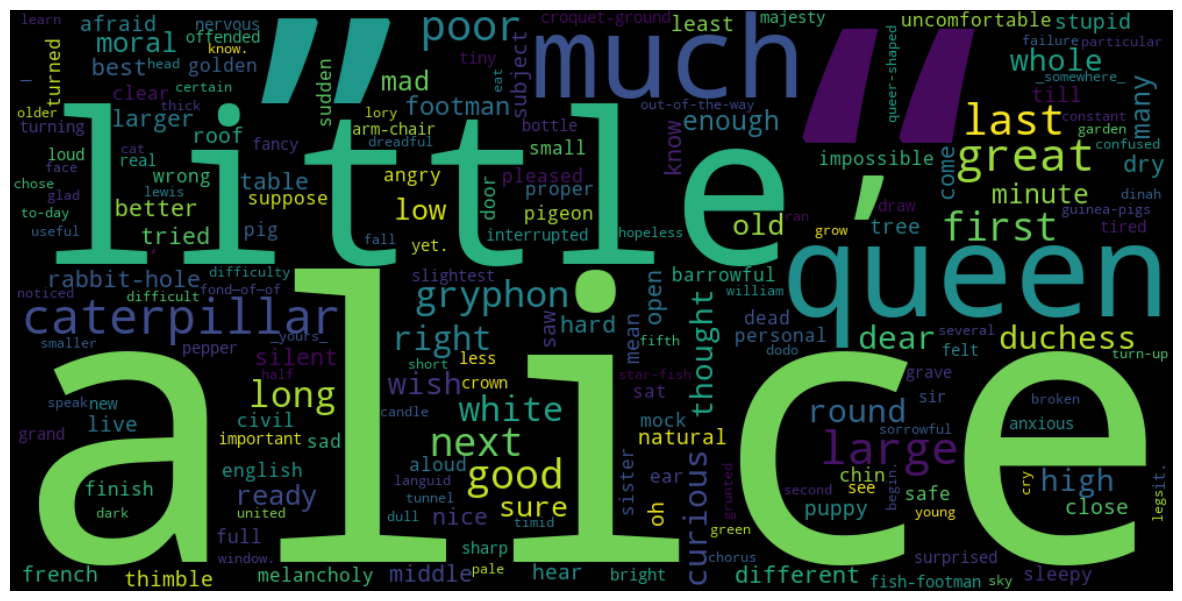

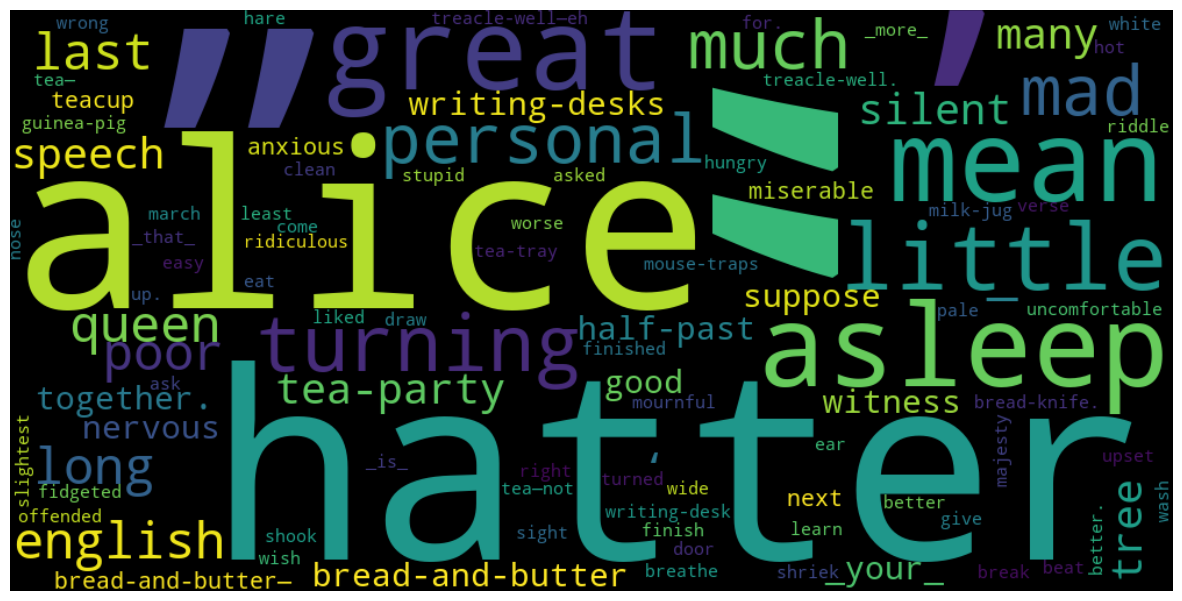

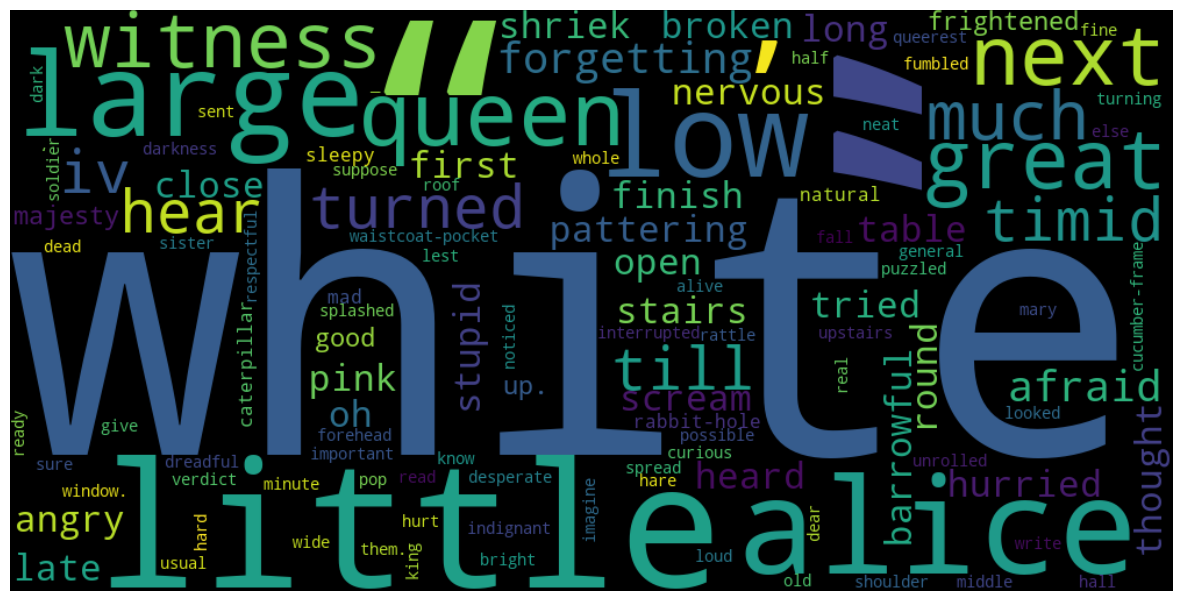

In [7]:
import nltk
import matplotlib.pyplot as plt
import requests
from wordcloud import WordCloud

nltk.download('averaged_perceptron_tagger')

# Read the text of the Gutenberg book into a string.
##r = requests .get("http://www.gutenberg.org/ebooks/521.txt.utf-8")

#text = cleanHtml (r.text) .lower()

text = books[book].lower()

tokens = nltk.word_tokenize(text)

# Remove stop words from the dictionary wf
tokens = [token for token in tokens if token not in stop_words]

tagged = nltk.pos_tag(tokens)

# Convert names to lowercase
english_names = [name.lower() for name in english_names]
name_tokens = []
# Filter out the tokens that are not in english_names
#name_tokens = [token for token in tokens if token in english_names and len(token) >= 5]

name_tokens.append("alice")
name_tokens.append("hatter")
name_tokens.append("rabbit")

# Get the frequency distribution of the name tokens
#freq_dist = nltk.FreqDist(name_tokens)

# Get the maximum frequency
#max_freq = max(freq_dist.values())

# Filter out the names that have the maximum frequency
#high_freq_names = [name for name, _ in freq_dist.most_common(10)]

#print(high_freq_names)


# For each high frequency name, create a graph
for name in name_tokens:

    # Create a dictionary to hold the frequency of each adjective
    adjective_freq = {}

    # Find adjectives that are within 25 words before or after the name
    for i, (word, pos) in enumerate(tagged):

        # Check if the word is the name (little hack for "crusoe" and "robinson crusoe")
        if word == name:
            
            # Extract 25 words before and after the name
            window = tagged[max(0, i - 15) : min(i + 15, len(tagged))]

            # Find adjectives within the window
            adjectives = [word for word, pos in window if pos.startswith('JJ')]

            # Add the frequency of each adjective to the dictionary
            for adj in adjectives:
                if adj in adjective_freq:
                    adjective_freq[adj] += 1
                else:
                    adjective_freq[adj] = 1

    # Create a word cloud
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(adjective_freq)

    # Display the word cloud
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


---

## Character Occurrence Frequency Analysis

### Text Selection and Reasoning

During the exploratory phase where we were exploring various books and approaches for this project, one of the ideas was to see how the frequnecy with which a character's name is used changes throughout the course of the book. With this ideas a mind, we picked a couple of books and just looked at the change in frequency of the main character. This book *Alice's Adventures in Wonderland by Lewis Carroll* had an interesting trend with the usage of **alice**, the main character, increased in the first half of the book and decreased in the second half.


### Analysis Overview

The aim of this analysis is to see how the frequency with which a character's name appears changes as the book progresses and to see if those trends can reveal something about the characters, plot, and book.

The hypothesis was we can construct a rough idea how many arcs there are in the book by inflow and outflow of characters and get a rough idea of what characters are related by when (and how much) they occur.

Some characters are identified by more than one word, for example, Mad Hatter. In such cases, we included trends for each word side-by-side to get a better idea of the occurence of such characters.

The character list is by no means exhaustive.

## 4. Final Analysis Summary and Reflection

### 4.1 - Character-Centric Analysis

#### 4.1.1 - Texts

During the exploratory phase where we were exploring various books and approaches for this project, one of the ideas was to see how the frequnecy with which a character's name is used changes throughout the course of the book. With this ideas a mind, we picked a couple of books and just looked at the change in frequency of the main character. This book *Alice's Adventures in Wonderland by Lewis Carroll* had an interesting trend with the usage of **alice**, the main character, increased in the first half of the book and decreased in the second half.

##### 4.1.1.1 - "The Adventures of Robinson Crusoe"

For our analysis of "The Adventures of Robinson Crusoe," we obtained the text from Project Gutenberg. The scope of our analysis was to read through the text and identify recurrences of the main character, Robinson Crusoe. We aimed to identify and analyze his characteristics, traits, and attributes.

### 4.2 - Character Occurence Frequency Analysis


The seems to be roughly 3 sections of the book.

* Section 1: Buckets 0-2 with characters like Alice, the White Rabbit, the Dodo, and Bill the Lizard appearing most.
* Section 2: Buckets 3-6 with lots of characters joining the fray. Alice, Mad Hatter, Cheshire Cat, the Queen and King of Hearts, Catepillar (who is more concentration towards the beginning of the section), the March Hare, and the Mock Turtle appear a lot.
* Sectio 3: Buckets 7-9 where Alice becomes less of a focus with her occurrence counts decreasing, but certain characters rising like Mad Hatter, the King and Queen of Hearts, the White Rabbit, and a little bit of Bill the Lizard.

Based on the large values of Alice's frequency, we can assume that she is likely an important (if the main) character of the story. The royalty seem to serve an important role in the plot towards the middle and latter half of the book. The middle of the book is where a lot of the content seems to be concentration with lots of character appearances.

Based on the cooccurence matrix, the seem to be three clusters of characters, cluster 1 is Alice, Mad Hatter, Cheshire Cat, March Hare, and the Mock Turtle, cluster 2 is the King and Queen of Hearts and the White Rabbit, clutser 3 is a bucket of all the remaining characters.

In summary, from observing the frequency with which character's identifying words appear, we can roughly figure out how many sections there are to the book (plot-wise), when one section transitions to another, and cluster groups of characters based on their appearance.

This analysis could be take a few steps further by including a more exhaustive list of characters, playing with the window size, change from word windows to chapter windows, analyzing the words surrounding each occurance of a character, and qualitatively analyzing hot stops where lots of characters coocur.
